In [1]:
import os
import numpy               as     np
import astropy.io.fits     as     fits
import pylab               as     pl
import pandas              as     pd
import matplotlib.pyplot   as     plt 

from   IPython.display     import YouTubeVideo
from   scipy               import interpolate
from   scipy               import optimize
from   tools.wave2rgb      import wavelength_to_rgb
from   tools.resample_flux import trapz_rebin

# Una enana blanca como la nieve

Cuando miras al cielo, ¿quién sabe qué encontrarás? Todos estamos familiarizados con nuestro propio [Sol](https://solarsystem.nasa.gov/solar-system/sun/overview/),

<img src="images/sun.jpg" alt="Drawing" style="width: 800px;"/>

aparentemente siempre presente, el cual vemos continuamente día a día. ¿Le sorprendería saber que en 5,500 millones de años el sol cambiará  y será irreconocible a medida que se agote la fusión nuclear que alimenta el hidrógeno?

<img src="images/RedGiant.jpg" alt="Drawing" style="width: 800px;"/>

Durante esta aparente crisis de la mediana edad, el sol comenzará a fusionar el helio para crear carbono, fundamental para la vida en la tierra, y oxígeno, necesario para sustentarla. Expandiéndose entre diez o cien veces el tamaño del Sol a día de hoy, pronto envolverá a Mercurio y Venus, y quizás [incluso a la Tierra misma](https://phys.org/news/2016-05-earth-survive-sun-red-giant.html#:~:text=Red%20Giant%20Phase%3A,collapses%20under%20its%20own%20weight.), y eventualmente explotará como una espectacular [nebulosas planetarias](https://es.wikipedia.org/wiki/Nebulosa_planetaria):

<img src="images/PlanetaryNebulae.jpg" alt="Drawing" style="width: 800px;"/>

El carbono-oxígeno ceniciento en el centro sobrevivirá como una reliquia fosilizada, disipando energía lo suficientemente lento como para que continúe sobreviviendo durante otros 13,8 mil millones de años, la edad actual de nuestro Universo, y ver en muchos más milenios.

Estudiando a las vecinas enanas blancas de la Vía Láctea podemos aprender sobre este eventual destino del Sol y su impacto en la Tierra.¡Veremos uno de estos objetos que DESI ha observado recientemente!

In [3]:
# Load the DESI spectrum
zbest = fits.open('../student_andes/zbest-mws-66003-20200315-wd.fits')[1]
coadd = fits.open('../student_andes/coadd-mws-66003-20200315-wd.fits')

In [4]:
# Get its position on the sky:
ra, dec = float(zbest.data['TARGET_RA']), float(zbest.data['TARGET_DEC'])

Su posición en el cielo nocturno se encuentra justo encima de la constelación [Ursa Marjor](https://es.wikipedia.org/wiki/Osa_Mayor) o la Osa Mayor,

<img src="images/UrsaMajor.jpg" alt="Drawing" style="width: 800px;"/>

familiar en el cielo nocturno:

<img src="images/UrsaMajor2.png" alt="Drawing" style="width: 800px;"/>

Si miraras el tiempo suficiente, verías un cambio casi imperceptible en la posición aparente conforme nuestro punto de vista cambia a medida que la Tierra orbita alrededor del Sol. Recuerda, ¡los dinosaurios vagaban por el planeta Tierra, cuando estaba al otro lado de la galaxia!

El movimiento de la Tierra alrededor del sol es suficiente, dado un instrumento lo suficientemente preciso, para calcular la distancia a nuestra Enana Blanca, con una trigonometría simple que probablemente ya hayas visto:

<img src="images/PDistance.jpg" alt="Drawing" style="width: 800px;"/>

El satélite espacial [GAIA](https://www.esa.int/Space_in_Member_States/Spain/Gaia_crea_el_mapa_estelar_mas_completo_de_nuestra_Galaxia_y_mas_alla) fue diseñado precisamente para hacer esto y eventualmente mapeará mil millones de estrellas en la Vía Láctea, aproximadamente una de cada cien allí, de esta manera.

<img src="images/Gaia.jpg" alt="Drawing" style="width: 800px;"/>

Con este paralaje, GAIA nos dice la distancia a nuestra enana blanca:

In [5]:
# Distancia calculada con paralaje de GAIA (Bailer-Jones et al. 2018).
# Datos de fotometría y de la [distancia calculda](https://ui.adsabs.harvard.edu/abs/2018AJ....156...58B/)
# pueden ser enconrados en los [archivos de GAIA](https://gea.esac.esa.int/archive/)
dist_para = 784.665266     # parcsecs, 1 parsec = 3.0857 x 10^16 m. 

parsec    = 3.085677581e16 # m 

# AU: Unidad astronómica - distancia entre el Sol y la Tierra.
au        = 1.495978707e11 # m

In [6]:
print(' El paralaje GAIA nos indica que la distancia a nuestra Enana Blanca es {:.0f} millones de veces la distancia de la Tierra al Sol'.format(dist_para * parsec / au / 1.e6))

 El paralaje GAIA nos indica que la distancia a nuestra Enana Blanca es 162 millones de veces la distancia de la Tierra al Sol


La cámara GAIA está diseñada para medir el brillo de la enana blanca en tres partes diferentes del espectro visible, correspondientes a los colores que se muestran a continuación. Reconocerás esto como el mismo estilo de diagrama que exploramos para las líneas de Hidrógeno en la Introducción.

In [7]:
#( Pivote) Longitud de onda de los filtros de GAIA DR2
GAIA = {'G_WAVE': 6230.6, 'BP_WAVE': 5051.5, 'RP_WAVE': 7726.2}

(380.0, 780.0)

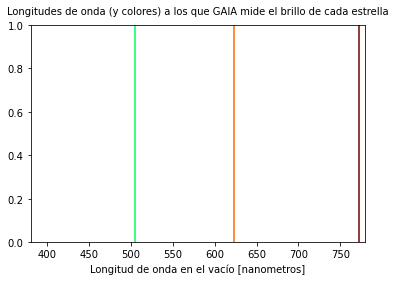

In [8]:
for wave in GAIA.values():
  # color = [r, g, b]
  color = wavelength_to_rgb(wave / 10.)       
  pl.axvline(x=wave / 10., c=color)

pl.title('Longitudes de onda (y colores) a los que GAIA mide el brillo de cada estrella', pad=10.5, fontsize=10)
pl.xlabel('Longitud de onda en el vacío [nanometros]')
pl.xlim(380., 780.)

In [9]:
for band in ['G', 'BP', 'RP']:
    GAIA[band + '_MAG']  = zbest.data['GAIA_PHOT_{}_MEAN_MAG'.format(band)][0]    
    GAIA[band + '_FLUX'] = 10.**(-(GAIA[band + '_MAG'] + (25.7934 - 25.6884)) / 2.5) * 3631. / 3.34e4 / GAIA[band + '_WAVE']**2.

In [10]:
# Añade los errores en la magnitud que los catálogos de DESI no contienen.
GAIA['G_MAGERR']  = 0.0044
GAIA['BP_MAGERR'] = 0.0281
GAIA['RP_MAGERR'] = 0.0780

In [11]:
for key, value in GAIA.items():
    print('{:10s} \t {:05.4f}'.format(key, value))

G_WAVE     	 6230.6000
BP_WAVE    	 5051.5000
RP_WAVE    	 7726.2000
G_MAG      	 19.5145
G_FLUX     	 0.0000
BP_MAG     	 19.3481
BP_FLUX    	 0.0000
RP_MAG     	 19.7099
RP_FLUX    	 0.0000
G_MAGERR   	 0.0044
BP_MAGERR  	 0.0281
RP_MAGERR  	 0.0780


Esta combinación, una medida de distancia (desde el paralaje) y de brillo aparente (en varios colores), es increíblemente poderosa, ya que juntas nos dicen la luminosidad o brillo intrínseco de la enana en lugar de cómo la percibimos, a partir de lo cual podemos determinar qué física podría estar determinando qué tan brillante es la enana blanca.

# DESI

Al resolver las variaciones sutiles en la cantidad de luz con la longitud de onda, DESI nos da una mucho mejor idea  de la composición de la Enana Blanca y su historia a partir de todo su espectro, en lugar de unas pocas mediciones en diferentes colores:

In [12]:
# Obten la longitud de onda y el flujo. 
wave  = coadd[1].data['WAVELENGTH']
count = coadd[1].data['TARGET35191335094848528']

Text(0.5, 1.0, 'TARGET35191335094848528')

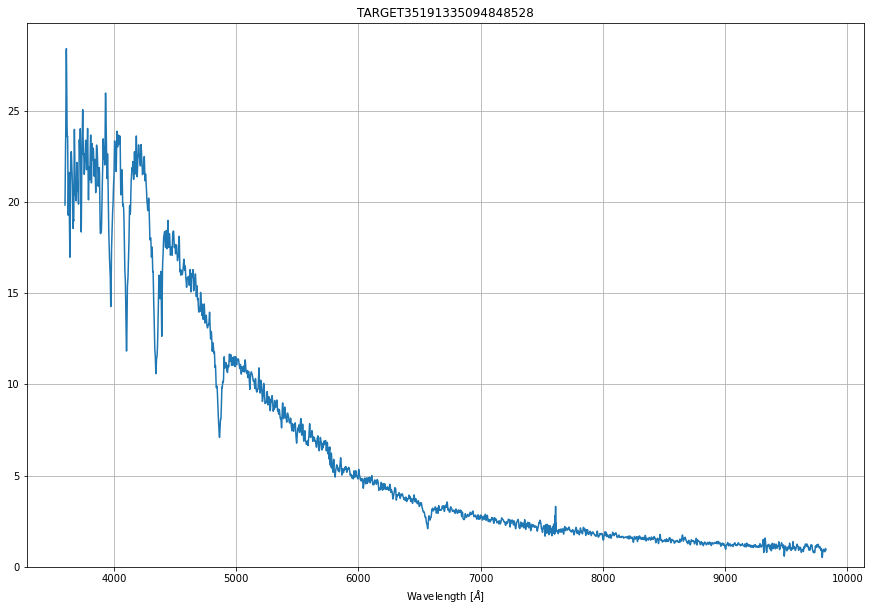

In [13]:
# Grafica el espectro de DESI
pl.figure(figsize=(15, 10))
pl.plot(wave, count)
pl.grid()
pl.xlabel('Wavelength $[\AA]$')
pl.ylim(ymin=0.)
pl.title('TARGET35191335094848528')

Los astrónomos han pasado mucho tiempo estudiando estrellas, clasificándolas de acuerdo a diferentes tipos - no menos importante [Annie Jump Cannon](https://www.mujeresenlahistoria.com/2014/08/besando-las-estrellas-annie-jump-cannon.html)([o en inglés](https://www.womenshistory.org/education-resources/biographies/annie-jump-cannon))

<img src="images/AnnieCannon.jpg" alt="Drawing" style="width: 800px;"/>

eso nos ha dejado con una nueva capacidad para predecir el espectro de una estrella a una temperatura determinada, $g$: la aceleración debida a la gravedad en su superficie, y su masa. Dadas las estrellas 'estándar', aquellas con restricciones de distancia externas, también podemos determinar qué tan intrínsecamente brillante es una estrella dada con un espectro determinado. Tomemos estos:

In [17]:
# Modelos de espectros de una enanas blancas
# [Levenhagen 2017](https://ui.adsabs.harvard.edu/abs/2017ApJS..231....1L)
spec_da_list       = os.listdir('../dat/WDspec/')
model_flux_spec_da = []
model_wave_spec_da = []

T_spec_da          = []
logg_spec_da       = []

# Haz un ciclo sobre todo los archivos en el directorio y únelos en una lista
# Loop over files in the directory and collect into a list. 
for filename in spec_da_list:
    if filename[-4:] != '.npz':
        continue
    model = np.load('../dat/WDspec/' + filename)['arr_0']
    model_flux_spec_da.append(model[:,1])
    model_wave_spec_da.append(model[:,0])
    T, logg = filename.split('.')[0].split('t0')[-1].split('g')
    T_spec_da.append(float(T) * 1000.)
    logg_spec_da.append(float(logg[:-1]) / 10.)
    
print(' {:d} Modelos de espectros colectados.'.format(len(spec_da_list)))

 66 Modelos de espectros colectados.


Text(0, 0.5, 'Flujo Normalizado')

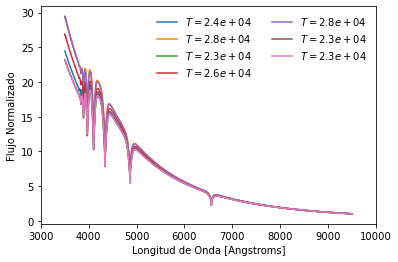

In [18]:
#Seleccionaremos uno de cada 10 modelos de enanas blancas para graficarlos

nth = 10

for model_wave, model_flux, model_temp in zip(model_wave_spec_da[::nth], model_flux_spec_da[::nth], T_spec_da[::nth]):
    pl.plot(model_wave, model_flux / model_flux[-1], label=r'$T = {:.1e}$'.format(model_temp))

# Otros comandos para la gráfica
pl.xlim(3000., 10000.)
# pl.ylim(ymin=1., ymax=3.6)
pl.legend(frameon=False, ncol=2)
pl.xlabel('Longitud de Onda [Angstroms]')
pl.ylabel('Flujo Normalizado')

En primer lugar, ¡estas enanas blancas están calientes! A 240,000 Kelvin, no debes tocar una. Podemos ver que la enana blanca más caliente es más brillante en una longitud de onda corta y, por lo tanto, aparecerá azul. Exactamente de la misma manera que la parte más azul de una llama es la más caliente:

<img src="images/bunsen.jpg" alt="Drawing" style="width: 280px;"/>

Así que ahora tenemos todo para encontrar la temperatura de la Enana Blanca que DESI pudo encontrar. Cómo hicimos en la Introducción, simplemente buscamos el modelo que se parece más a los datos.

In [19]:
# rango de longitud de onda que será ajustado
wave_min = 3750.
wave_max = 5200.

sq_diff  = []

# Haciendo una máscara en el rango que será ajustado

fitted_range = (wave > wave_min) & (wave < wave_max)
fitted_wave  =  wave[fitted_range] 

for model_wave, model_flux in zip(model_wave_spec_da, model_flux_spec_da):
    # Remuestreo de la resolución del modelo para ajustar al espectro observado
    model_flux_resampled = trapz_rebin(model_wave, model_flux, fitted_wave)
    
    # Calcula la suma cuadrática de la diferencia de los modelos individuales, normalizados, y el espectro observado.
    sq_diff.append(np.sum((model_flux_resampled / np.median(model_flux_resampled) - count[fitted_range] / np.median(count[fitted_range]))**2.))

# Mejor ajuste por mínimos cuadrados ponderados, de la gravedad superficial y la temperatura a partir del espectro de DESI
arg_min   = np.argmin(sq_diff)
T_desi    = T_spec_da[arg_min]
logg_desi = logg_spec_da[arg_min]

Text(0.5, 1.0, 'DESI White Dwarf:   Temperature = 26000.0 K;  $\\log_{10}$(g) = 7.6')

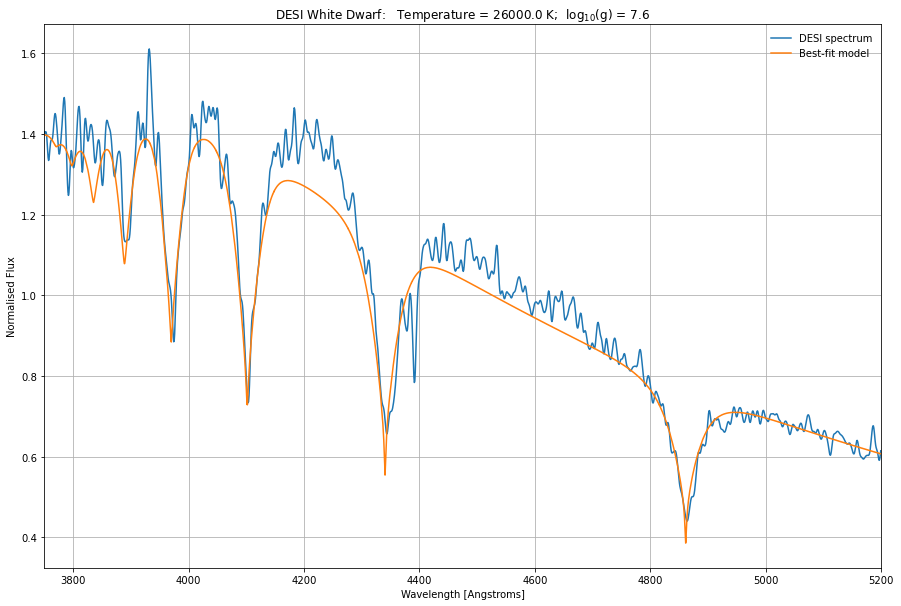

In [20]:
# Grafica solo el mejor ajuste
fitted_range = (model_wave_spec_da[arg_min] > wave_min) & (model_wave_spec_da[arg_min] < wave_max)
fitted_range_data = (wave > wave_min) & (wave < wave_max)

pl.figure(figsize=(15, 10))
pl.plot(wave[fitted_range_data], count[fitted_range_data] / np.median(count[fitted_range_data]), label='DESI spectrum')
pl.plot(model_wave_spec_da[arg_min][fitted_range], model_flux_spec_da[arg_min][fitted_range] / np.median(model_flux_spec_da[arg_min][fitted_range]), label='Best-fit model')
pl.grid()
pl.xlim(wave_min, wave_max)
pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Normalised Flux')
pl.legend(frameon=False)
pl.title('DESI White Dwarf:   Temperature = ' + str(T_desi) + ' K;  $\log_{10}$(g) = ' + str(logg_desi))

Así que nuestra enana blanca tiene unos 26,000 Kelvin. Mientras que la gravedad superficial sería insoportable. Si recuerda, la aceleración gravitacional se deriva de la masa y el radio de un cuerpo como $g = \frac{G \cdot M}{r^2}$ y es aproximadamente una medida de cuán denso es un objeto. Veamos cómo se ve esto para algunas fuentes conocidas

In [23]:
logg = pd.read_csv('../dat/logg.txt', sep='\s+', comment='#', names=['Cuerpo', 'Gravedad en superficie [g]'])
logg = logg.sort_values('Gravedad en superficie [g]')
logg

,Cuerpo,Gravedad en superficie [g]
6,Phobos,0.000581
12,Pluto,0.063000
9,Europa,0.134000
4,Moon,0.165000
8,Io,0.183000
1,Mercury,0.377000
5,Mars,0.379000
2,Venus,0.905000
3,Earth,1.000000
10,Saturn,1.065000


Text(0, 0.5, 'Gravedad en Superficie [g]')

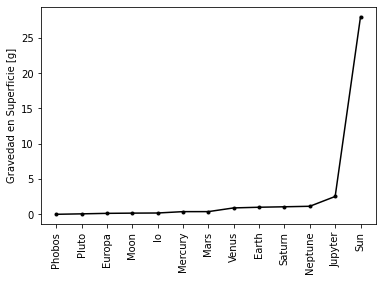

In [25]:
fig, ax = plt.subplots()

pl.plot(np.arange(0, len(logg), 1), logg['Gravedad en superficie [g]'], marker='.', c='k')

plt.xticks(np.arange(len(logg)))
ax.set_xticklabels(logg['Cuerpo'], rotation='vertical')
ax.set_ylabel('Gravedad en Superficie [g]')

Entonces, la aceleración en Júpiter es algunas veces mayor que en la Tierra, mientras que en el Sol sería 30 veces mayor. La fuerza que se siente durante el despegue de un vuelo es aproximadamente un 30% mayor que la aceleración debida a la gravedad en la Tierra. Para nuestra enana blanca de DESI, la aceleración debida a la gravedad en la superficie es:

In [26]:
logg = 7.6 

g    = 10.**7.6 # cm2 / s.
g   /= 100.     # m2 / s

g   /= 9.81     # Relative to that on Earth, i.e. [g].   
g

40581.770698623535

veces mayor que en la Tierra! De hecho, si no fuera por las extrañas restricciones sobre lo que los electrones pueden y no pueden hacer (según lo determinado por la Mecánica Cuántica), la Enana Blanca sería tan densa que colapsaría por completo. ¡Imagínate!

Ahora es tu turno. ¿Puedes encontrar una clase de objeto incluso más densa que una enana blanca? ¿Cuál es la aceleración debida a la gravedad en su superficie?

¡Más difícil! ¡Puede que seas uno de los primeros en ver a esta Enana Blanca 'de cerca'! ¿Qué más puedes averiguar al respecto? Aquí hay algo para comenzar ...